# Homework 5

# Задача №1 - Можете ли вы отличить сорняки от рассады?

Теперь приступим к задаче классификации на картинках. Реализуйте программу, которая определяет тип рассады на изображении. 

Для того, чтобы определить характерные особенности каждого типа рассады, у вас есть train. Train это папка, в которой картинки уже классифицированы и лежат в соответствующих папках. Исходя из этой информации можете найти признаки, присущие конкретному растению.

Проверка вашего решения будет на происходить на test. В папке test уже нет метки класса для каждой картинки. 

[Ссылка на Яндекс-диск](https://yadi.sk/d/0Zzp0klXT0iRmA), все картинки тут.

Примеры изображений для теста:
<table><tr>
    <td> <img src="https://i.ibb.co/tbqR37m/fhj.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/6yL3Wmt/sfg.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/pvn7NvF/asd.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [ ]:
# type : ignore
import os
from glob import glob
from typing import List, Optional

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


class PlantClassifier:
    def __init__(self, vocabulary_size: int = 50):
        self.vocabulary_size = vocabulary_size
        self.__kmeans = None
        self.__classifier = None
        self.__class_names = []

    def _ExtractSiftFeatures(self, image_path: str) -> Optional[np.ndarray]:
        image = cv2.imread(image_path)

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        green_mask = cv2.inRange(hsv_image, (35, 50, 50), (85, 255, 255))
        
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        masked_image = cv2.bitwise_and(gray_image, gray_image, mask=green_mask)
        
        sift = cv2.SIFT_create()
        _, descriptors = sift.detectAndCompute(masked_image, None)
        
        return descriptors

    def _BuildVisualVocabulary(self, image_paths: List[str]) -> None:

        all_descriptors = [self._ExtractSiftFeatures(path) for path in image_paths]
        all_descriptors = np.vstack(all_descriptors)
        
        self.__kmeans = KMeans(n_clusters=self.vocabulary_size, random_state=42, n_init='auto')
        self.__kmeans.fit(all_descriptors)

    def _CreateFeatureVector(self, image_path: str) -> np.ndarray:
        descriptors = self._ExtractSiftFeatures(image_path)
        
        visual_words = self.__kmeans.predict(descriptors)
        hist, _ = np.histogram(visual_words, bins=self.vocabulary_size, range=(0, self.vocabulary_size))
        
        hist = hist.astype(np.float32)
        if hist.sum() > 0:
            hist /= hist.sum()
            
        return hist

    def Train(self, train_dir: str) -> None:        
        self.__class_names = sorted([
            d for d in os.listdir(train_dir) 
            if os.path.isdir(os.path.join(train_dir, d))
        ])
        
        image_paths = []
        labels = []
        
        for class_idx, class_name in enumerate(self.__class_names):
            class_path = os.path.join(train_dir, class_name)
            for img_path in glob(os.path.join(class_path, "*.png")):
                image_paths.append(img_path)
                labels.append(class_idx)
        
        print("Building visual vocabulary...")
        self._BuildVisualVocabulary(image_paths)
        
        print("Creating training features...")
        X_train = [self._CreateFeatureVector(path) for path in image_paths]
        X_train = np.array(X_train)
        y_train = np.array(labels)
        
        print("Training classifier...")
        self.__classifier = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(max_iter=1000))
        ])
        self.__classifier.fit(X_train, y_train)

    def Predict(self, image_path: str) -> tuple:
        features = self._CreateFeatureVector(image_path)
        probabilities = self.__classifier.predict_proba([features])[0]
        
        top_class_idx = np.argmax(probabilities)
        
        return (
            self.__class_names[top_class_idx], #'top_class'
            top_class_idx, #'class_index'
            float(probabilities[top_class_idx]) # 'confidence'
        )

    def Evaluate(self, test_dir: str, true_labels: List[int]) -> float:

        test_images = glob(os.path.join(test_dir, "*.png"))
        
        predictions = [self.Predict(img_path)[1] for img_path in test_images]
        
        return accuracy_score(true_labels, predictions)



train_dir = "plants/train"
test_dir = "plants/test"

true_labels = [
    0, 0, 1, 1, 0, 0, 2, 3, 1, 0, 1, 1, 0, 3, 2, 3, 2, 3, 0, 3, 
    2, 2, 3, 1, 3, 2, 2, 1, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 1
    ]

classifier = PlantClassifier(vocabulary_size=50)
classifier.Train(train_dir)

accuracy = classifier.Evaluate(test_dir, true_labels)
print(f"Model accuracy: {accuracy:.2%}\n")

Building visual vocabulary...
Creating training features...
Training classifier...
Model accuracy: 100.00%



# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

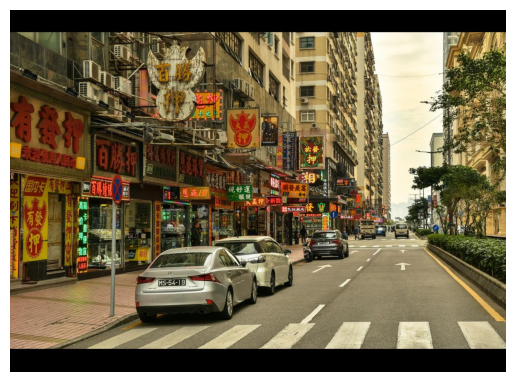

In [ ]:
import matplotlib.pyplot as plt

def FindOffset(points, transformed_points):
    best_offset = None
    best_loss = np.inf
    loss_f = lambda x1, x2: np.linalg.norm(x1 - x2)
    
    for point, transformed_point in zip(points, transformed_points):
        offset = (transformed_point - point)[:2]
        transformation = np.eye(3)
        transformation[:2, 2] = offset
        transformed_points = (transformation @ points.T).T  
        transformed_points = np.divide(transformed_points.T, transformed_points[:, 2]).T
        tmp_loss = loss_f(transformed_points, transformed_points)
        
        if tmp_loss < best_loss:
            best_loss = tmp_loss
            best_offset = offset
    return best_offset

def GetShift(first, second):
    nfetures = first.size // second.size * 5000
    
    hyp_params2 = dict(
        nfeatures=5000,
        nOctaveLayers=7,
        contrastThreshold=0.03,
        edgeThreshold=10,
        sigma=1.6
    ) 
    
    hyp_params1 = dict(
        nfeatures=nfetures,
        nOctaveLayers=7,
        contrastThreshold=0.03,
        edgeThreshold=10,
        sigma=1.6
    )
    
    sift2 = cv2.SIFT_create(**hyp_params2)
    sift1 = cv2.SIFT_create(**hyp_params1)
    
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=2, trees=15)
    search_params = dict(checks=150)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    kp1, des1 = sift1.detectAndCompute(first, None)
    kp2, des2 = sift2.detectAndCompute(second, None)

    if des2 is None or des1 is None:
        return None
    
    try:
        matches = flann.knnMatch(des1, des2, k=2)
        ratio_thresh = 0.2
        good_matches = []
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    except:
        return None
    
    if len(good_matches) == 0:
        return None
    
    points = np.array([[kp1[m.queryIdx].pt[1], kp1[m.queryIdx].pt[0], 1] for m in good_matches])
    transformed_points = np.array([[kp2[m.trainIdx].pt[1], kp2[m.trainIdx].pt[0], 1] for m in good_matches])
    
    shift = FindOffset(transformed_points, points)
    if shift is not None:
        shift[0] = round(shift[0])
        shift[1] = round(shift[1])
    return shift

def SwitchImagesRightDown(left, right, shift):
    new_shape = [max(left.shape[0], right.shape[0] + shift[0]), 
                max(left.shape[1], right.shape[1] + shift[1]), 
                3]
    new_image = np.zeros(shape=new_shape)
    
    new_image[0 : left.shape[0], 0 : left.shape[1], :] = left
    new_image[shift[0] : right.shape[0] + shift[0], shift[1] : right.shape[1] + shift[1], :] = right
    
    return new_image.astype(np.uint8)

def SwitchImages(first, second):
    shift = GetShift(first, second)
    if shift is None:
        return None
    
    shift = np.array(shift, dtype=np.int32)
    
    if shift[0] < 0:
        first = np.pad(first, ((-shift[0], 0), (0, 0), (0, 0)))
        shift[0] = 0

    if shift[1] < 0:
        first = np.pad(first, ((0, 0), (-shift[1], 0), (0, 0)))
        shift[1] = 0

    result = SwitchImagesRightDown(first, second, shift)
    return result

image_paths = []
# puzzle_dir = 'puzzle/su_fighter_shuffle' # Меньше 10 секунд
puzzle_dir = 'puzzle/china_shuffle' # Пару минут
# puzzle_dir = 'puzzle/home_shuffle' # Около часа
image_paths.extend(glob(os.path.join(puzzle_dir, "*.jpg")))

images = [cv2.imread(image_path) for image_path in image_paths]
index = [i for i in range(len(images))]
base_image = images[0]
index.remove(0)

while len(index) > 0:
    cant_add = True
    for i in index:
        img = images[i]
        shift = GetShift(base_image, img)
        if shift is not None:
            cant_add = False
            base_image = SwitchImages(base_image, img)
            index.remove(i)
            break
    
    if cant_add:
        print("Can't solve puzzle")
        break

base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)
plt.imshow(base_image)
plt.axis('off')
plt.show()